# Relation Extraction Classification
Binary Classification Model using TF-IDF and Bag of words as features

In [ ]:
import re
import pandas as pd
import random
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
import string
import logging

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load the extracted dataset

In [ ]:
trainDataSource = pd.read_csv('trainDataset.csv')
devDataSource = pd.read_csv('devDataset.csv')

In [ ]:
trainDataSource.head()

,Unnamed: 0,id,sentence,T1,T1_starting_postion,T1_ending_position,T1_type,T2,T2_starting_postion,T2_ending_position,T2_type,relation_type
0,0,0101_E1 Tob,"Tob (-), EtOH - a glass of wine 1-2x/month, I...",Tob,1,3,Tobacco,(-),5,7,StatusTime,Status
1,1,0101_E2 Tob,"Tob (-), EtOH - a glass of wine 1-2x/month, I...",EtOH,10,13,Alcohol,EtOH,10,13,StatusTime,Status
2,2,0101_E2 Tob,"Tob (-), EtOH - a glass of wine 1-2x/month, I...",EtOH,10,13,Alcohol,a glass,17,23,Amount,Amount
3,3,0101_E2 Tob,"Tob (-), EtOH - a glass of wine 1-2x/month, I...",EtOH,10,13,Alcohol,1-2x/month,33,42,Frequency,Frequency
4,4,0101_E2 Tob,"Tob (-), EtOH - a glass of wine 1-2x/month, I...",EtOH,10,13,Alcohol,wine,28,31,Type,Type


In [ ]:
devDataSource.head()

,Unnamed: 0,id,sentence,T1,T1_starting_postion,T1_ending_position,T1_type,T2,T2_starting_postion,T2_ending_position,T2_type,relation_type
0,0,0403_E1 Liv,Lives with his caring and devoted parents at...,Lives,2,6,LivingStatus,Lives,2,6,StatusTime,Status
1,1,0403_E1 Liv,Lives with his caring and devoted parents at...,Lives,2,6,LivingStatus,with his caring and devoted parents,8,42,TypeLiving,Type
2,2,0403_E2 No h,"No history of alcohol, tobacco or drug use.",tobacco,25,31,Tobacco,No history,2,11,StatusTime,Status
3,3,0403_E3 No h,"No history of alcohol, tobacco or drug use.",drug use,36,43,Drug,No history,2,11,StatusTime,Status
4,4,0403_E4 No h,"No history of alcohol, tobacco or drug use.",alcohol,16,22,Alcohol,No history,2,11,StatusTime,Status


In [ ]:
devDataSource.isna().sum()

Unnamed: 0             0
id                     3
sentence               3
T1                     0
T1_starting_postion    0
T1_ending_position     0
T1_type                0
T2                     0
T2_starting_postion    0
T2_ending_position     0
T2_type                0
relation_type          0
dtype: int64

In [ ]:
trainDataSource.pivot_table(index=['relation_type', 'T2_type','T1_type'], aggfunc='count')

T1  T1_ending_position  \
relation_type T2_type      T1_type                                  
Amount        Amount       Alcohol        315                 315   
                           Drug            10                  10   
                           Tobacco        558                 558   
Amount2       Amount       Alcohol          7                   7   
                           Tobacco         27                  27   
Amount3       Amount       Tobacco          1                   1   
Duration      Duration     Alcohol         84                  84   
                           Drug            23                  23   
                           Employment      49                  49   
                           LivingStatus    37                  37   
                           Tobacco        296                 296   
Duration2     Duration     Alcohol          1                   1   
                           Tobacco          5                   5   
Frequency     Frequency    Alcohol        322                 322   
                           Drug            24                  24   
                           Tobacco        196                 196   
Frequency2    Frequency    Alcohol          4                   4   
History       History      Alcohol        147                 147   
                           Drug           100                 100   
                           Employment      49                  49   
                           LivingStatus    19                  19   
                           Tobacco        304                 304   
History2      History      Alcohol          1                   1   
Method        Method       Drug           193                 193   
                           Tobacco          5                   5   
Method2       Method       Drug             2                   2   
Status        StatusEmploy Employment     980                 980   
              StatusTime   Alcohol       1292                1292   
                           Drug           985                 985   
                           LivingStatus   959                 959   
                           Tobacco       1230                1230   
Status2       StatusEmploy Employment       1                   1   
              StatusTime   Alcohol          2                   2   
                           Drug             1                   1   
                           Tobacco          2                   2   
Type          Type         Alcohol        186                 186   
                           Drug           663                 663   
                           Employment     695                 695   
                           Tobacco        153                 153   
              TypeLiving   LivingStatus   959                 959   
Type2         Type         Alcohol          8                   8   
                           Drug            20                  20   
                           Employment      12                  12   
                           Tobacco          2                   2   
Type3         Type         Alcohol          1                   1   
                           Drug             2                   2   
                           Employment       1                   1   

                                         T1_starting_postion    T2  \
relation_type T2_type      T1_type                                   
Amount        Amount       Alcohol                       315   315   
                           Drug                           10    10   
                           Tobacco                       558   558   
Amount2       Amount       Alcohol                         7     7   
                           Tobacco                        27    27   
Amount3       Amount       Tobacco                         1     1   
Duration      Duration     Alcohol                        84    84   
                           Drug

In [ ]:
cleanTrainDF = trainDataSource.dropna().reset_index()
cleanDevDF = devDataSource.dropna().reset_index()

In [ ]:
cleanTrainDF['fileName'] = cleanTrainDF['id'].apply(lambda x: x.split("_")[0])
cleanDevDF['fileName'] = cleanDevDF['id'].apply(lambda x: x.split("_")[0])

In [ ]:
for file in cleanTrainDF['fileName'].unique():
  if(file in cleanDevDF['fileName']):
    print(file, end = " ")

In [ ]:
cleanTrainDF['relation_type'].unique()

array(['Status', 'Amount', 'Frequency', 'Type', 'Method', 'Duration',
       'History', 'Type2', 'Type3', 'Amount2', 'Duration2', 'Frequency2',
       'Status2', 'History2', 'Amount3', 'Method2'], dtype=object)

In [ ]:
cleanTrainDF.shape

(10823, 14)

In [ ]:
# extract only 'Amount' and 'History' relation type
twoClassCleanTrainDF = cleanTrainDF[(cleanTrainDF['relation_type'] == 'Amount') | (cleanTrainDF['relation_type'] == 'History')]
twoClassCleanDevDF = cleanDevDF[(cleanDevDF['relation_type'] == 'Amount') | (cleanDevDF['relation_type'] == 'History')]

In [ ]:
twoClassCleanTrainDF.head()

,index,Unnamed: 0,id,sentence,T1,T1_starting_postion,T1_ending_position,T1_type,T2,T2_starting_postion,T2_ending_position,T2_type,relation_type,fileName
2,2,2,0101_E2 Tob,"Tob (-), EtOH - a glass of wine 1-2x/month, I...",EtOH,10,13,Alcohol,a glass,17,23,Amount,Amount,0101
16,16,16,0104_E2 Curr,Currently admits to five drinks of alcohol pe...,alcohol,37,43,Alcohol,five drinks,22,32,Amount,Amount,0104
26,26,26,0104_E6 Smok,Smokes 1-1.5 packs per day x20 years.,Smokes,2,7,Tobacco,1-1.5 packs,9,19,Amount,Amount,0104
32,32,32,0105_E2 She,She quit smoking 30 years ago.,smoking,11,17,Tobacco,30 years ago,19,30,History,History,0105
36,36,36,0106_E2 Liv,"Lives with wife in [**Location (un) 538**], ...",smoking,70,76,Tobacco,60 pack year,46,57,Amount,Amount,0106


In [ ]:
# combine Train and Dev data frame
twoClassCompleteDF = pd.concat([twoClassCleanTrainDF, twoClassCleanDevDF])

In [ ]:
def converter(relation):
  # convert relation_type to binary
    if relation == 'History':
        return 1
    elif relation == 'Amount':
        return 0

In [ ]:
twoClassCompleteDF['relation_type'] = twoClassCompleteDF['relation_type'].apply(converter)

In [ ]:
twoClassCompleteDF.head()

,index,Unnamed: 0,id,sentence,T1,T1_starting_postion,T1_ending_position,T1_type,T2,T2_starting_postion,T2_ending_position,T2_type,relation_type,fileName
2,2,2,0101_E2 Tob,"Tob (-), EtOH - a glass of wine 1-2x/month, I...",EtOH,10,13,Alcohol,a glass,17,23,Amount,0,0101
16,16,16,0104_E2 Curr,Currently admits to five drinks of alcohol pe...,alcohol,37,43,Alcohol,five drinks,22,32,Amount,0,0104
26,26,26,0104_E6 Smok,Smokes 1-1.5 packs per day x20 years.,Smokes,2,7,Tobacco,1-1.5 packs,9,19,Amount,0,0104
32,32,32,0105_E2 She,She quit smoking 30 years ago.,smoking,11,17,Tobacco,30 years ago,19,30,History,1,0105
36,36,36,0106_E2 Liv,"Lives with wife in [**Location (un) 538**], ...",smoking,70,76,Tobacco,60 pack year,46,57,Amount,0,0106


In [ ]:
print('Number of "History" samples:', (twoClassCompleteDF.relation_type == 1).sum())
print('Number of "Amount" samples:',  (twoClassCompleteDF.relation_type == 0).sum())
print('Total samples:', len(twoClassCompleteDF))

Number of "History" samples: 670
Number of "Amount" samples: 949
Total samples: 1619


In [ ]:
# split the training data into positive and negative
rows_his = twoClassCompleteDF.relation_type == 1
df_his = twoClassCompleteDF.loc[rows_his]
df_amt = twoClassCompleteDF.loc[~rows_his]

# merge the balanced data
df = pd.concat([df_his, df_amt.sample(n = len(df_his), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df = df.sample(n = len(df), random_state = 42).reset_index(drop = True)

In [ ]:
print('Number of "History" samples:', (df.relation_type == 1).sum())
print('Number of "Amount" samples:',  (df.relation_type == 0).sum())
print('Prevalence: (n = %d):'%len(df), df.relation_type.sum()/ len(df))

Number of "History" samples: 670
Number of "Amount" samples: 670
Prevalence: (n = 1340): 0.5


In [ ]:
# for training the model we use sentence as features
# and relation type as target
twoclass_df = df[['sentence', 'relation_type']]
twoclass_df.head()

,sentence,relation_type
0,"Family from [**Male First Name (un) 1056**], ...",1
1,Lived by himself since divorce in [**2159**];...,0
2,He use to drink alcohol but has abstained for...,1
3,"Former heavy EtOH use, sober x 35 years.",1
4,Prior to that he hadn't used any cocaine for ...,1


In [ ]:
twoclass_df.shape

(1340, 2)

### Using Tfidf approach to train models

In [ ]:
lemmatizer = WordNetLemmatizer()

def customtokenize(str):
    tokens=nltk.word_tokenize(str)
    ntokens = nltk.RegexpTokenizer(r"\w+")
    words = ntokens.tokenize(str)
    nostop = list(filter(lambda token: token not in stopwords.words('english'), words))
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

def getTFIDFMatrix(df):
  vectorizer = TfidfVectorizer(tokenizer=customtokenize)
  tfidf_data = vectorizer.fit_transform(df['sentence'])
  return pd.DataFrame(tfidf_data.toarray(),columns=vectorizer.get_feature_names_out())

In [ ]:
tfidf_df = getTFIDFMatrix(twoclass_df)

In [ ]:
tfidf_df.shape

(1340, 1726)

In [ ]:
tfidf_df

,0,03,08,1,10,100,100054,100py,102899,102900,...,year,yes,yesterday,yet,yo,young,younger,youth,yr,yres
0,0.0,0.0,0.0,0.057394,0.0,0.117966,0.0,0.0,0.0,0.0,...,0.037102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.194795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.136196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.158556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.263835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,0.0,0.0,0.0,0.119862,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1336,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.112214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1337,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.270103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1338,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.286673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, twoclass_df['relation_type'], test_size=0.30, random_state=111)

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train, y_train)

LogisticRegression(C=0.0001, random_state=42)

In [ ]:
model = clf
y_lr_preds = model.predict(X_test)

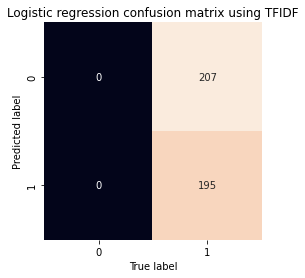


Accuracy of prediction: 0.485


In [ ]:
# Visualize confusion matrix for logistic regression
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_lr_preds, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Logistic regression confusion matrix using TFIDF')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for logistic regression using TFIDF\n")
print(classification_report(y_test,y_lr_preds))

classification report for logistic regression using TFIDF

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       207
           1       0.49      1.00      0.65       195

    accuracy                           0.49       402
   macro avg       0.24      0.50      0.33       402
weighted avg       0.24      0.49      0.32       402



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Train a decision tree model
from sklearn.tree import DecisionTreeClassifier 

trees_giniIndex = DecisionTreeClassifier()
trees_giniIndex.fit(X_train, y_train)

tree_entropy = DecisionTreeClassifier(criterion='entropy')
tree_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
# Predict using the decision tree models
y_pred_ent = tree_entropy.predict(X_test)

y_pred_gini = trees_giniIndex.predict(X_test)

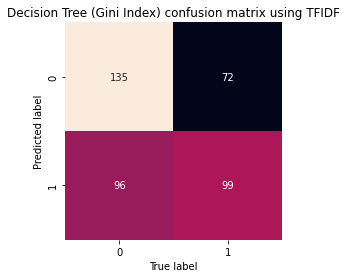


Accuracy of prediction: 0.582


In [ ]:
# Evaluate confusion matrix for decision tree using Gini
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_gini, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Decision Tree (Gini Index) confusion matrix using TFIDF')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for Decision Tree (Gini Index) using TFIDF\n")
print(classification_report(y_test,y_pred_gini))

classification report for Decision Tree (Gini Index) using TFIDF

              precision    recall  f1-score   support

           0       0.58      0.65      0.62       207
           1       0.58      0.51      0.54       195

    accuracy                           0.58       402
   macro avg       0.58      0.58      0.58       402
weighted avg       0.58      0.58      0.58       402



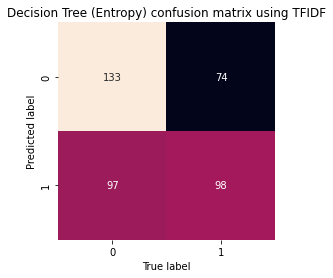


Accuracy of prediction: 0.575


In [ ]:
# Evaluate confusion matrix for decision tree using Entropy
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_ent, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Decision Tree (Entropy) confusion matrix using TFIDF')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for Decision Tree (Entropy) using TFIDF\n")
print(classification_report(y_test,y_pred_ent))

classification report for Decision Tree (Entropy) using TFIDF

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       207
           1       0.57      0.50      0.53       195

    accuracy                           0.57       402
   macro avg       0.57      0.57      0.57       402
weighted avg       0.57      0.57      0.57       402



In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel="poly", degree=1, C=0.1, gamma=0.1)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

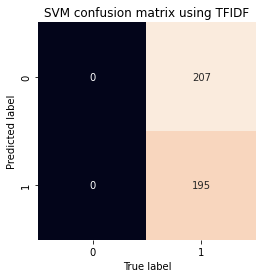


Accuracy of prediction: 0.485


In [ ]:
# Evaluate confusion matrix for decision tree using Entropy
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_svc, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('SVM confusion matrix using TFIDF')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for SVM using TFIDF\n")
print(classification_report(y_test,y_pred_svc))

classification report for SVM using TFIDF

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       207
           1       0.49      1.00      0.65       195

    accuracy                           0.49       402
   macro avg       0.24      0.50      0.33       402
weighted avg       0.24      0.49      0.32       402



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfc = RandomForestClassifier(max_depth=10, random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

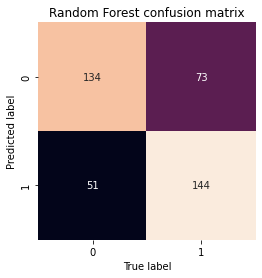


Accuracy of prediction: 0.692


In [ ]:
# Evaluate confusion matrix for decision tree using Entropy
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_rfc, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Random Forest confusion matrix')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for Random Forest using TFIDF\n")
print(classification_report(y_test,y_pred_svc))

classification report for Random Forest using TFIDF

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       207
           1       0.49      1.00      0.65       195

    accuracy                           0.49       402
   macro avg       0.24      0.50      0.33       402
weighted avg       0.24      0.49      0.32       402



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred_nb = gaussian.predict(X_test)

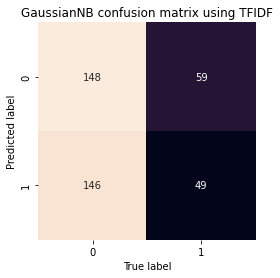


Accuracy of prediction: 0.49


In [ ]:
# Evaluate confusion matrix for decision tree using Entropy
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_nb, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('GaussianNB confusion matrix using TFIDF')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for GaussianNB using TFIDF\n")
print(classification_report(y_test,y_pred_nb))

classification report for GaussianNB using TFIDF

              precision    recall  f1-score   support

           0       0.50      0.71      0.59       207
           1       0.45      0.25      0.32       195

    accuracy                           0.49       402
   macro avg       0.48      0.48      0.46       402
weighted avg       0.48      0.49      0.46       402



### Using bag of words approach to train models

In [ ]:
lemmatizer = WordNetLemmatizer()

def customtokenize(str):
    tokens=nltk.word_tokenize(str)
    ntokens = nltk.RegexpTokenizer(r"\w+")
    words = ntokens.tokenize(str)
    nostop = list(filter(lambda token: token not in stopwords.words('english'), words))
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

def getBagOfWords(df):
  CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
  Count_data = CountVec.fit_transform(df['sentence'])
  return pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())

In [ ]:
BOW_df = getBagOfWords(twoclass_df)

In [ ]:
BOW_df.shape

(1340, 1725)

In [ ]:
BOW_df

,03,08,10,100,100054,100py,102899,102900,102901,102902,...,years,yes,yesterday,yo,young,younger,youth,yr,yres,yrs
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1336,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1338,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(BOW_df, twoclass_df['relation_type'], test_size=0.30, random_state=111)

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train, y_train)

LogisticRegression(C=0.0001, random_state=42)

In [ ]:
model = clf
y_lr_preds = model.predict(X_test)

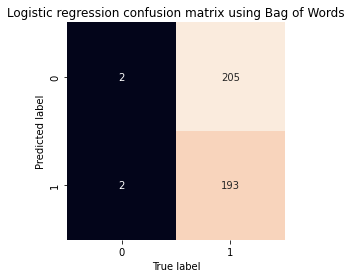


Accuracy of prediction: 0.485


In [ ]:
# Visualize confusion matrix for logistic regression
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_lr_preds, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Logistic regression confusion matrix using Bag of Words')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for logistic regression using Bag of Words\n")
print(classification_report(y_test,y_lr_preds))

classification report for logistic regression using Bag of Words

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       207
           1       0.48      0.99      0.65       195

    accuracy                           0.49       402
   macro avg       0.49      0.50      0.33       402
weighted avg       0.49      0.49      0.33       402



In [ ]:
# Train a decision tree model
from sklearn.tree import DecisionTreeClassifier 

trees_giniIndex = DecisionTreeClassifier()
trees_giniIndex.fit(X_train, y_train)

tree_entropy = DecisionTreeClassifier(criterion='entropy')
tree_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
# Predict using the decision tree models
y_pred_ent = tree_entropy.predict(X_test)

y_pred_gini = trees_giniIndex.predict(X_test)

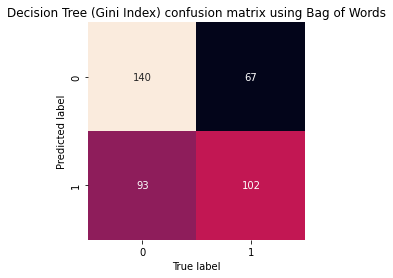


Accuracy of prediction: 0.602


In [ ]:
# Evaluate confusion matrix for decision tree using Gini
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_gini, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Decision Tree (Gini Index) confusion matrix using Bag of Words')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for Decision Tree (Gini Index) using Bag of Words\n")
print(classification_report(y_test,y_pred_gini))

classification report for Decision Tree (Gini Index) using Bag of Words

              precision    recall  f1-score   support

           0       0.60      0.68      0.64       207
           1       0.60      0.52      0.56       195

    accuracy                           0.60       402
   macro avg       0.60      0.60      0.60       402
weighted avg       0.60      0.60      0.60       402



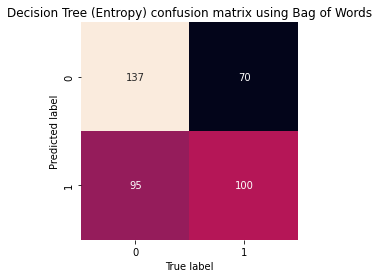


Accuracy of prediction: 0.59


In [ ]:
# Evaluate confusion matrix for decision tree using Entropy
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_ent, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Decision Tree (Entropy) confusion matrix using Bag of Words')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for Decision Tree (Entropy) using Bag of Words\n")
print(classification_report(y_test,y_pred_ent))

classification report for Decision Tree (Entropy) using Bag of Words

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       207
           1       0.59      0.51      0.55       195

    accuracy                           0.59       402
   macro avg       0.59      0.59      0.59       402
weighted avg       0.59      0.59      0.59       402



In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel="poly", degree=1, C=0.1, gamma=0.1)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

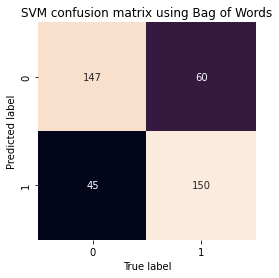


Accuracy of prediction: 0.739


In [ ]:
# Evaluate confusion matrix for decision tree using Entropy
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_svc, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('SVM confusion matrix using Bag of Words')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for SVM using Bag of Words\n")
print(classification_report(y_test,y_pred_svc))

classification report for SVM using Bag of Words

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       207
           1       0.71      0.77      0.74       195

    accuracy                           0.74       402
   macro avg       0.74      0.74      0.74       402
weighted avg       0.74      0.74      0.74       402



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfc = RandomForestClassifier(max_depth=10, random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

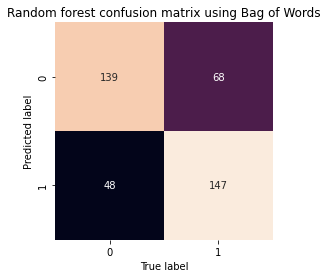


Accuracy of prediction: 0.711


In [ ]:
# Evaluate confusion matrix for decision tree using Entropy
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_rfc, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Random forest confusion matrix using Bag of Words')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for Random Forest using Bag of Words\n")
print(classification_report(y_test,y_pred_rfc))

classification report for Random Forest using Bag of Words

              precision    recall  f1-score   support

           0       0.74      0.67      0.71       207
           1       0.68      0.75      0.72       195

    accuracy                           0.71       402
   macro avg       0.71      0.71      0.71       402
weighted avg       0.71      0.71      0.71       402



In [ ]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred_nb = gaussian.predict(X_test)

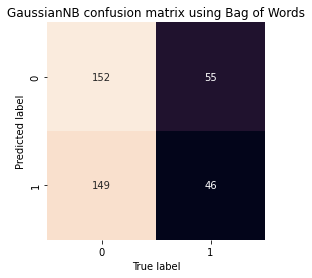


Accuracy of prediction: 0.493


In [ ]:
# Evaluate confusion matrix for decision tree using Entropy
from sklearn.metrics import classification_report,confusion_matrix 
import seaborn as sns

lr_mat = confusion_matrix(y_pred_nb, y_test)

sns.heatmap(lr_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('GaussianNB confusion matrix using Bag of Words')
plt.show()

print ("\nAccuracy of prediction:",round((lr_mat[0,0]+lr_mat[1,1])/lr_mat.sum(),3))

In [ ]:
print("classification report for GaussianNB using Bag of Words\n")
print(classification_report(y_test,y_pred_nb))

classification report for GaussianNB using Bag of Words

              precision    recall  f1-score   support

           0       0.50      0.73      0.60       207
           1       0.46      0.24      0.31       195

    accuracy                           0.49       402
   macro avg       0.48      0.49      0.45       402
weighted avg       0.48      0.49      0.46       402



### Spacy

In [ ]:
!pip install spacy
!pip install spacy_sentence_bert

In [ ]:
! pip install -U pip setuptools wheel
! pip install -U spacy
! python -m spacy download en_core_web_sm

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')
def getCorpus(sentences):
  corpus = []
  for row in range(0, len(sentences)):
    str_tokens=[]
    tokens= nlp(sentences[row]).ents
    for i in range(0, len(tokens)):
      str_tokens.append(tokens[i].text)
    corpus.append(list(str_tokens))
  return corpus

In [ ]:
corpus=getCorpus(twoclass_df['sentence'])

In [ ]:
from gensim.models import Word2Vec
word2vec = Word2Vec(corpus, min_count=1, size=100)

In [ ]:
vocabulary = word2vec.wv.vocab
print(vocabulary)

{'First': <gensim.models.keyedvectors.Vocab object at 0x7eff1cce0f10>, 'un': <gensim.models.keyedvectors.Vocab object at 0x7eff1cce0110>, '1056': <gensim.models.keyedvectors.Vocab object at 0x7eff1ccd0f90>, '531': <gensim.models.keyedvectors.Vocab object at 0x7eff1ccd09d0>, 'age 6 Live': <gensim.models.keyedvectors.Vocab object at 0x7eff1ccd0610>, '100%': <gensim.models.keyedvectors.Vocab object at 0x7eff1cd28310>, '3 months': <gensim.models.keyedvectors.Vocab object at 0x7eff1cd28890>, '+Tobacco - 2': <gensim.models.keyedvectors.Vocab object at 0x7eff1cd28ed0>, '20+ years': <gensim.models.keyedvectors.Vocab object at 0x7eff1ccd0c90>, '2100': <gensim.models.keyedvectors.Vocab object at 0x7eff1cd3bf10>, '2113': <gensim.models.keyedvectors.Vocab object at 0x7eff1cd28cd0>, 'Pine': <gensim.models.keyedvectors.Vocab object at 0x7eff1cd28690>, '3 months ago': <gensim.models.keyedvectors.Vocab object at 0x7eff1cd28650>, '2159': <gensim.models.keyedvectors.Vocab object at 0x7eff1cd28390>, 'app

In [ ]:
print(word2vec.wv['last night'])

[ 2.5718529e-03 -2.3110559e-04 -1.3458458e-03  1.4841030e-03
  2.0826780e-04  4.1329497e-03 -5.2432436e-04  1.2600679e-03
  1.6329953e-04 -4.2358392e-05 -2.9347066e-03  3.7339432e-04
  1.8680672e-03  2.6098627e-04 -2.3380760e-03  8.2401995e-04
 -1.7819327e-04  3.9145928e-03  3.9252371e-04 -1.8149419e-03
 -4.2605540e-03  1.2327331e-03 -4.6974970e-03 -4.5036045e-03
 -3.9989813e-03  9.2807104e-04 -4.5575856e-04 -4.8522120e-03
  4.0016538e-03 -3.8773971e-04 -4.7701159e-03 -4.9814079e-03
 -2.5248940e-03 -3.9523207e-03  3.4546943e-03  4.2329188e-03
  4.7598574e-03  3.1352362e-03 -1.1809927e-03  3.0295644e-04
  1.0382989e-03  1.8383655e-03  1.8661357e-04 -2.2022594e-03
 -3.6126266e-03 -3.0403326e-03 -1.7959308e-03 -2.9055465e-03
 -2.2444227e-03 -4.2786184e-03 -1.6120420e-03 -4.5870421e-03
  2.6966459e-03 -3.2236304e-03 -4.1805264e-03 -3.7316135e-03
  3.3750704e-03  6.1781786e-04 -3.9825840e-03  9.8235253e-04
 -9.7566796e-04  5.3135323e-04  4.4048722e-03  4.0225565e-04
  7.2982733e-04  6.58979

In [ ]:
# finding similar words
sim_words = word2vec.wv.most_similar('last night')
for i in sim_words:
  print(i)

('1.5 months', 0.31473779678344727)
('19 years ago', 0.28132662177085876)
('Methadone', 0.27066177129745483)
('>1.5 years', 0.26790952682495117)
('Hx', 0.2585104703903198)
('3 years ago', 0.24035921692848206)
('4 months ago', 0.23172371089458466)
('2115', 0.23092633485794067)
('22 months', 0.2234121710062027)
('marijuana', 0.2178557813167572)


In [ ]:
w2v_weights = df_Spacy_Word2Vec.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [ ]:
def word2token(word, w2v_model):
    try:
        return w2v_model.wv.vocab[word].index
    except KeyError:
        return 0

def token2word(token, w2v_model):
    return w2v_model.wv.index2word[token]

https://www.kaggle.com/code/kstathou/word-embeddings-logistic-regression/notebook

In [ ]:
from sklearn.preprocessing import LabelEncoder

def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in word2vec.wv.vocab]
    return np.mean(word2vec[doc], axis=0)

In [ ]:
vector = twoclass_df.sentence.apply(document_vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


ValueError: ignored

http://ethen8181.github.io/machine-learning/keras/text_classification/word2vec_text_classification.html